# DLMI - Lymphocytosis classification
## Simples baselines

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings

from sklearn import (
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    svm,
    tree
)
from torch.utils.data import DataLoader, Dataset

warnings.filterwarnings(action="ignore")
plt.style.use("seaborn-whitegrid")

In [2]:
data_dir = "../data/dlmi-lymphocytosis-classification/"
compute_age = lambda x: 2024 - int(x.replace("-", "/").split("/")[-1])
gender_to_int = lambda x: 1 if x.lower() == "m" else 0

In [3]:
trainset_data_df = pd.read_csv(data_dir + "trainset/trainset_true.csv")
trainset_data_df["AGE"] = trainset_data_df["DOB"].apply(compute_age)
trainset_data_df["GENDER"] = trainset_data_df["GENDER"].apply(gender_to_int)
trainset_data_df.head(2)

,ID,LABEL,GENDER,DOB,LYMPH_COUNT,AGE
0,P26,1,1,11/3/1933,11.2,91
1,P183,1,1,5/15/1942,12.8,82


In [4]:
testset_data_df = pd.read_csv(data_dir + "testset/testset_data.csv")
testset_data_df["AGE"] = testset_data_df["DOB"].apply(compute_age)
testset_data_df["GENDER"] = testset_data_df["GENDER"].apply(gender_to_int)
testset_data_df.head(2)

,ID,LABEL,GENDER,DOB,LYMPH_COUNT,AGE
0,P71,-1,1,1/17/1946,5.76,78
1,P16,-1,1,3/5/1940,32.00,84


In [5]:
selected_columns = ["GENDER", "LYMPH_COUNT", "AGE"]
X_train_val = trainset_data_df[selected_columns].to_numpy(dtype=np.float32)
X_test = testset_data_df[selected_columns].to_numpy(dtype=np.float32)
y_train_val = trainset_data_df["LABEL"].to_numpy(dtype=int)
X_train_val.shape, X_test.shape

((163, 3), (42, 3))

In [6]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_val, y_train_val)

In [7]:
def fit_predict(clf):
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_train)
    acc = metrics.accuracy_score(y_train, y_pred)
    balanced_acc = metrics.balanced_accuracy_score(y_train, y_pred)
    print(f"Train : acc = {acc:.2f} bal. acc = {balanced_acc:.2f}")

    y_pred = clf.predict(X_val)
    acc = metrics.accuracy_score(y_val, y_pred)
    balanced_acc = metrics.balanced_accuracy_score(y_val, y_pred)
    print(f"Val : acc = {acc:.2f} bal. acc = {balanced_acc:.2f}")

In [8]:
for clf in [
    linear_model.LogisticRegression(class_weight="balanced"),
    tree.DecisionTreeClassifier(class_weight="balanced"),
    svm.SVC(class_weight="balanced"),
    ensemble.RandomForestClassifier(class_weight="balanced"),
    naive_bayes.MultinomialNB()
]:
    print(clf.__class__)
    fit_predict(clf)
    print()

<class 'sklearn.linear_model._logistic.LogisticRegression'>
Train : acc = 0.84 bal. acc = 0.86
Val : acc = 0.83 bal. acc = 0.89

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
Train : acc = 1.00 bal. acc = 1.00
Val : acc = 0.83 bal. acc = 0.82

<class 'sklearn.svm._classes.SVC'>
Train : acc = 0.84 bal. acc = 0.81
Val : acc = 0.80 bal. acc = 0.80

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Train : acc = 1.00 bal. acc = 1.00
Val : acc = 0.83 bal. acc = 0.85

<class 'sklearn.naive_bayes.MultinomialNB'>
Train : acc = 0.58 bal. acc = 0.67
Val : acc = 0.59 bal. acc = 0.69



### Logistic Regression

In [9]:
clf = linear_model.LogisticRegression(class_weight="balanced")
clf.fit(X_train_val, y_train_val)
y_pred = clf.predict(X_train_val)
acc = metrics.accuracy_score(y_train_val, y_pred)
balanced_acc = metrics.balanced_accuracy_score(y_train_val, y_pred)
print(f"Train : acc = {acc:.2f} bal. acc = {balanced_acc:.2f}")

Train : acc = 0.86 bal. acc = 0.88


In [10]:
y_test_pred = clf.predict(X_test)
submission_df = testset_data_df[["ID"]]
submission_df["LABEL"] = y_test_pred
submission_df = submission_df.rename({"ID": "Id", "LABEL": "Predicted"}, axis=1)
submission_df.head(15)

,Id,Predicted
0,P71,0
1,P16,1
2,P114,1
3,P170,1
4,P98,0
5,P69,0
6,P92,1
7,P132,1
8,P81,1
9,P73,1


In [11]:
submission_df.to_csv("../submissions/logistic_regression.csv", index=False)

### Neural network

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [27]:
class LDataset(Dataset):

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

    def __len__(self):
        return len(self.Y)


class XDataset(Dataset):

    def __init__(self, X):
        self.X = X

    def __getitem__(self, index):
        return self.X[index]

    def __len__(self):
        return len(self.X)

In [14]:
def test(model, loss_fn, dataloader):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = torch.FloatTensor(X).to(device)
            y = torch.LongTensor(y).to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    accuracy /= size
    return test_loss, accuracy

In [15]:
def train(model, optimizer, loss_fn, dataloader):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, accuracy = 0, 0
    for X, y in dataloader:
        X = torch.FloatTensor(X).to(device)
        y = torch.LongTensor(y).to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    train_loss /= num_batches
    accuracy /= size
    return train_loss, accuracy

In [16]:
def trainer(model, optimizer, loss_fn, train_dataloader, test_dataloader, n_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, n_epochs + 1):
        train_loss, train_accuracy = train(model, optimizer, loss_fn, train_dataloader)
        test_loss, test_accuracy = test(model, loss_fn, test_dataloader)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        if epoch % 10 == 0:
            print(f"[Epoch {epoch} / {n_epochs}] train loss = {train_loss:.2f} acc = {train_accuracy:.2f} ",
                f"test loss = {test_loss:.2f} acc = {test_accuracy:.2f}")

    return (train_losses, train_accuracies), (test_losses, test_accuracies)

In [33]:
def nn_predict(model, dataloader):
    y = []
    model.eval()
    with torch.no_grad():
        for X in dataloader:
            X = torch.FloatTensor(X).to(device)
            logits = model(X)
            pred = F.softmax(logits, dim=-1).argmax(dim=-1)
            y.extend(pred.cpu().detach().numpy().tolist())
    return np.array(y)

In [17]:
batch_size = 8
train_dataset = LDataset(X_train, y_train)
test_dataset = LDataset(X_val, y_val)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [44]:
X_train_val_dataset = XDataset(X_train_val)
X_val_dataset = XDataset(X_val)
X_test_dataset = XDataset(X_test)
X_train_val_dataloader = DataLoader(X_train_val_dataset, batch_size=batch_size, shuffle=False)
X_val_dataloader = DataLoader(X_val_dataset, batch_size=batch_size, shuffle=False)
X_test_dataloader = DataLoader(X_test_dataset, batch_size=batch_size, shuffle=False)

[Epoch 10 / 100] train loss = 0.47 acc = 0.70  test loss = 0.34 acc = 0.76
[Epoch 20 / 100] train loss = 0.37 acc = 0.81  test loss = 0.28 acc = 0.88
[Epoch 30 / 100] train loss = 0.36 acc = 0.84  test loss = 0.22 acc = 0.88
[Epoch 40 / 100] train loss = 0.33 acc = 0.85  test loss = 0.23 acc = 0.85
[Epoch 50 / 100] train loss = 0.31 acc = 0.87  test loss = 0.21 acc = 0.88
[Epoch 60 / 100] train loss = 0.36 acc = 0.81  test loss = 0.19 acc = 0.90
[Epoch 70 / 100] train loss = 0.32 acc = 0.85  test loss = 0.22 acc = 0.83
[Epoch 80 / 100] train loss = 0.29 acc = 0.85  test loss = 0.18 acc = 0.90
[Epoch 90 / 100] train loss = 0.28 acc = 0.84  test loss = 0.24 acc = 0.83
[Epoch 100 / 100] train loss = 0.31 acc = 0.84  test loss = 0.18 acc = 0.90


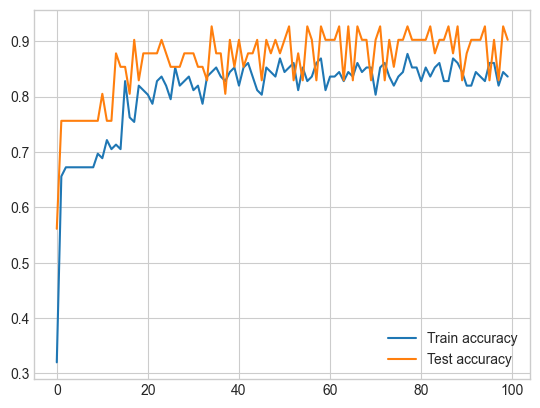

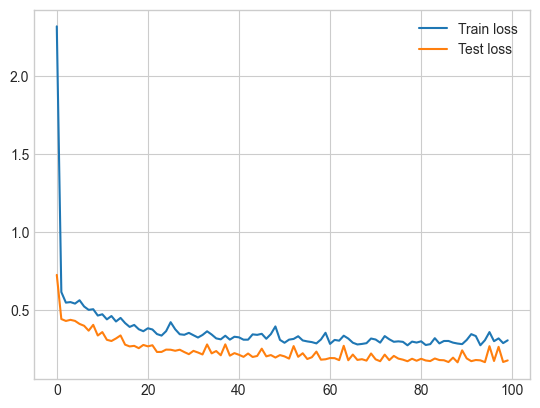

In [25]:
model = nn.Sequential(
    nn.Linear(3, 8),
    nn.ReLU(),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Linear(4, 2)
).to(device)
lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
loss_fn = nn.CrossEntropyLoss()

n_epochs = 100
(train_losses, train_accuracies), (test_losses, test_accuracies) = trainer(
    model, optimizer, loss_fn, train_dataloader, test_dataloader, n_epochs
)

plt.figure()
plt.plot(train_accuracies, label="Train accuracy")
plt.plot(test_accuracies, label="Test accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.legend()
plt.show()

In [29]:
train_test_dataset = LDataset(X_train_val, y_train_val)
train_test_dataloader = DataLoader(train_test_dataset, batch_size=batch_size, shuffle=False)
test(model, loss_fn, train_test_dataloader)

(0.28479841564382824, 0.8773006134969326)

In [37]:
y_pred = nn_predict(model, X_val_dataloader)
acc = metrics.accuracy_score(y_val, y_pred)
balanced_acc = metrics.balanced_accuracy_score(y_val, y_pred)
print(f"acc = {acc:.2f} bal. acc = {balanced_acc:.2f}")

acc = 0.90 bal. acc = 0.90


[Epoch 10 / 100] train loss = 0.49 acc = 0.71  test loss = 0.47 acc = 0.79
[Epoch 20 / 100] train loss = 0.41 acc = 0.77  test loss = 0.42 acc = 0.82
[Epoch 30 / 100] train loss = 0.39 acc = 0.82  test loss = 0.37 acc = 0.83
[Epoch 40 / 100] train loss = 0.37 acc = 0.83  test loss = 0.34 acc = 0.84
[Epoch 50 / 100] train loss = 0.36 acc = 0.83  test loss = 0.32 acc = 0.84
[Epoch 60 / 100] train loss = 0.35 acc = 0.84  test loss = 0.31 acc = 0.84
[Epoch 70 / 100] train loss = 0.34 acc = 0.84  test loss = 0.34 acc = 0.82
[Epoch 80 / 100] train loss = 0.32 acc = 0.86  test loss = 0.32 acc = 0.84
[Epoch 90 / 100] train loss = 0.33 acc = 0.84  test loss = 0.30 acc = 0.85
[Epoch 100 / 100] train loss = 0.34 acc = 0.82  test loss = 0.29 acc = 0.85


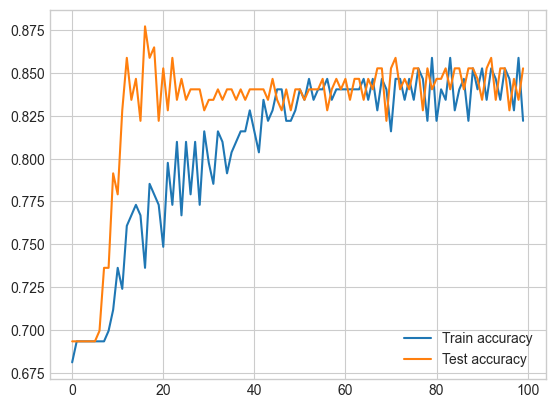

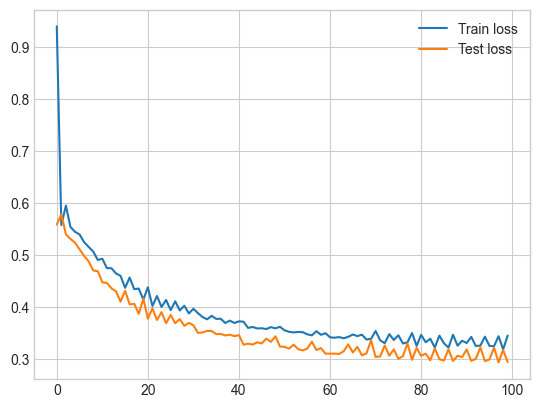

In [42]:
model = nn.Sequential(
    nn.Linear(3, 8),
    nn.ReLU(),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Linear(4, 2)
).to(device)
lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
loss_fn = nn.CrossEntropyLoss()

n_epochs = 100
(train_losses, train_accuracies), (test_losses, test_accuracies) = trainer(
    model, optimizer, loss_fn, train_test_dataloader, train_test_dataloader, n_epochs
)

plt.figure()
plt.plot(train_accuracies, label="Train accuracy")
plt.plot(test_accuracies, label="Test accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.legend()
plt.show()

In [45]:
y_test_pred = nn_predict(model, X_test_dataloader)
submission_df = testset_data_df[["ID"]]
submission_df["LABEL"] = y_test_pred
submission_df = submission_df.rename({"ID": "Id", "LABEL": "Predicted"}, axis=1)
submission_df.head(15)

,Id,Predicted
0,P71,0
1,P16,1
2,P114,1
3,P170,1
4,P98,0
5,P69,1
6,P92,1
7,P132,1
8,P81,1
9,P73,1


In [46]:
submission_df.to_csv("../submissions/nn_baseline.csv", index=False)